In [1]:
import numpy
import torch
import torch.nn.functional as F
import logging
logging.basicConfig(level=logging.INFO)

from myTorch.task.copying_memory import CopyingMemoryData
from myTorch.memnets.load import load_experiment
import matplotlib.pyplot as plt


/home/sarath/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
models = list()
model_names = list()
model_colors = list()
models.append("/mnt/data/sarath/mytorch_savedir/output/copying_memory_task/ex01/current")
model_names.append("RNN")
model_colors.append("r")
models.append("/mnt/data/chinna/output/copying_memory_task/mask_1/current")
model_names.append("LSTM")
model_colors.append("b")
models.append("/mnt/data/chinna/output/copying_memory_task/flatmemory_m64_k4_h80_linear/current")
model_names.append("FlatMemory")
model_colors.append("g")


In [3]:
def get_stats(save_dir):
    experiment, model, data_iterator, device, config = load_experiment(save_dir)
    config.time_lag = 100
    config.batch_size = 1
    config.seed = 1000
    new_data_iterator = CopyingMemoryData(seq_len=config.seq_len, time_lag=config.time_lag,
                                          batch_size=config.batch_size, seed=config.seed)
    data_iterator = new_data_iterator
    
    data = data_iterator.next()
    seqloss = 0

    model.reset_hidden(batch_size=1)

    hiddens = []

    for i in range(0, data["datalen"]):

        x = torch.from_numpy(numpy.asarray(data['x'][i])).to(device)
        y = torch.from_numpy(numpy.asarray(data['y'][i])).to(device)
        mask = float(data["mask"][i])

        model.optimizer.zero_grad()

        output = model(x)
        hiddens.append(model._h_prev[0]["h"])
        hiddens[-1].requires_grad_()
        if config.task == "copying_memory":
            loss = F.torch.nn.functional.cross_entropy(output, y.squeeze(1))
        else:
            loss = F.binary_cross_entropy_with_logits(output, y)

        seqloss += (loss * mask)

    seqloss /= sum(data["mask"])

    hidden_norms = list()
    hidden_diff = list()
    hidden_grads = list()
    for i in range(0, len(hiddens)):
        hidden_diff.append((hiddens[i]-hiddens[-1]).norm().item())
        hidden_norms.append(hiddens[i].norm().item())
    for i in range(0, len(hiddens)):
        model.optimizer.zero_grad()
        grad = torch.autograd.grad(loss, hiddens[i], retain_graph=True)
        hidden_grads.append(grad[0].norm().item())
    return hidden_norms, hidden_diff, hidden_grads
    

In [4]:
hidden_norm_list = list()
hidden_diff_list = list()
hidden_grad_list = list()

for i in range(0, len(models)):
    hidden_norm, hidden_diff, hidden_grad = get_stats(models[i])
    hidden_norm_list.append(hidden_norm)
    hidden_diff_list.append(hidden_diff)
    hidden_grad_list.append(hidden_grad)

INFO:root:using cpu
/mnt/data/sarath/code/myTorch/myTorch/memory/RNNCell.py:80: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(self._W_i2h, gain=nn.init.calculate_gain(self._activation))
/mnt/data/sarath/code/myTorch/myTorch/memnets/recurrent_net.py:84: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(self._W_h2o, gain=nn.init.calculate_gain(self._output_activation))
/mnt/data/sarath/code/myTorch/myTorch/memnets/recurrent_net.py:85: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(self._b_o, 0)
INFO:root:Loading the experiment from /mnt/data/sarath/mytorch_savedir/output/copying_memory_task/ex01


Num_params : 8009 


INFO:root:using cpu
INFO:root:Loading the experiment from /mnt/data/chinna/output/copying_memory_task/mask_1


Num_params : 8649 


INFO:root:using cpu
INFO:root:Loading the experiment from /mnt/data/chinna/output/copying_memory_task/flatmemory_m64_k4_h80_linear


Num_params : 23569 


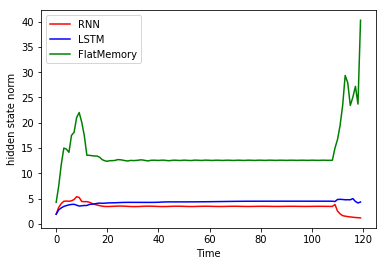

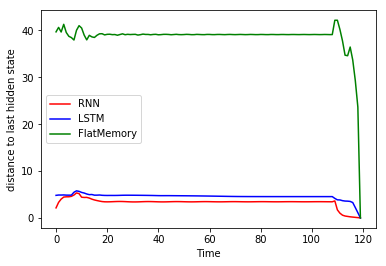

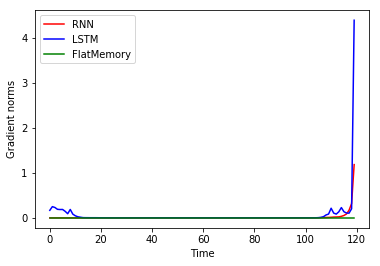

In [5]:
for i in range(0, len(models)):
    plt.plot(hidden_norm_list[i], color=model_colors[i], label=model_names[i])

plt.ylabel('hidden state norm')
plt.xlabel('Time')
plt.legend()
plt.show()


for i in range(0, len(models)):
    plt.plot(hidden_diff_list[i], color=model_colors[i], label=model_names[i])

plt.ylabel('distance to last hidden state')
plt.xlabel('Time')
plt.legend()
plt.show()

for i in range(0, len(models)):
    plt.plot(hidden_grad_list[i], color=model_colors[i], label=model_names[i])

plt.ylabel('Gradient norms')
plt.xlabel('Time')
plt.legend()
plt.show()